# basic-002
https://chatgpt.com/c/680282ad-266c-800a-99bd-7eeb6918b9f9

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2025-04-18 21:37:56.440856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744999676.455641   21831 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744999676.460292   21831 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 21:37:56.473440: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# ==== CONFIG ====
SEQ_LEN = 60
FUTURE_CANDLES = 100
COLUMNS = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

In [3]:
# ==== LOAD DATA ====
df_train = pd.read_csv("../datasets/XAGUSD-H1-rates.csv", sep=r'\s+', engine='python', names=["DATE", "TIME", "OPEN", "HIGH", "LOW", "CLOSE", "TICKVOL", "VOL", "SPREAD"], skiprows=1)
df_test = pd.read_csv("../datasets/new-data-for-test/rows-30-from-20240503.csv", sep=r'\s+', engine='python', names=["DATE", "TIME", "OPEN", "HIGH", "LOW", "CLOSE", "TICKVOL", "VOL", "SPREAD"], skiprows=1)

In [4]:
# Drop unnecessary columns
df_train = df_train[COLUMNS]
df_test = df_test[COLUMNS]

# ==== SCALE ====
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train)
test_scaled = scaler.transform(df_test)

In [5]:
# ==== PREPARE TRAINING SEQUENCES ====
X_train, y_train = [], []
for i in range(SEQ_LEN, len(train_scaled)):
    X_train.append(train_scaled[i-SEQ_LEN:i])
    y_train.append(train_scaled[i, :4])  # Predict OHLC
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
# ==== MODEL ====
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, len(COLUMNS))),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(4)  # Output: OHLC
])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64)

I0000 00:00:1744999678.683058   21831 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/saeed/repositories/machine-learning/tensorflow-course/start-tensorflow/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


I0000 00:00:1744999681.277913   21872 cuda_dnn.cc:529] Loaded cuDNN version 90800


860/860 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8767 - loss: 0.0066
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9781 - loss: 8.1823e-05
Epoch 3/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9769 - loss: 6.8420e-05
Epoch 4/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9768 - loss: 5.5109e-05
Epoch 5/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9776 - loss: 5.1383e-05
Epoch 6/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9769 - loss: 4.2106e-05
Epoch 7/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9768 - loss: 3.1976e-05
Epoch 8/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9778 - loss: 2.7755e-05
Epoch 9/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9754 - loss: 2.1814e-05
Epoch 10/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9770 - loss: 2.2076e-05


In [7]:
# ==== PREDICT NEXT 100 CANDLES ====
# Use last 30 candles from train + 30 from test = 60
combined_input = np.vstack([train_scaled[-30:], test_scaled])
input_seq = combined_input.tolist()
predictions_scaled = []

for _ in range(FUTURE_CANDLES):
    x_input = np.array(input_seq[-SEQ_LEN:]).reshape(1, SEQ_LEN, len(COLUMNS))
    pred = model.predict(x_input, verbose=0)[0]
    next_candle = np.concatenate([pred, [input_seq[-1][-1]]])  # Use same TICKVOL as last known
    input_seq.append(next_candle)
    predictions_scaled.append(pred)


In [8]:
# ==== INVERSE SCALE ====
# Combine 30 real + 100 predicted candles
real_scaled = test_scaled[-30:, :4]
combined_scaled = np.vstack([real_scaled, predictions_scaled])

# Pad to full shape before inverse_transform
pad_tickvol = np.zeros((130, 1))
padded_scaled = np.hstack([combined_scaled, pad_tickvol])
real_plus_pred = scaler.inverse_transform(padded_scaled)[:, :4]  # Get OHLC

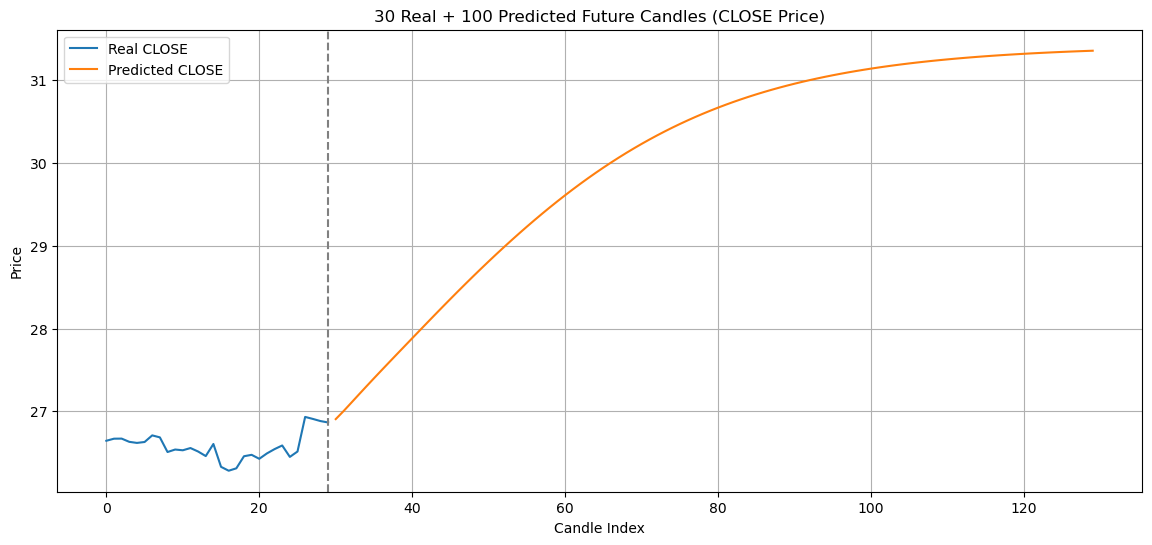

In [9]:
# ==== PLOT ====
plt.figure(figsize=(14, 6))
plt.plot(range(30), real_plus_pred[:30, 3], label='Real CLOSE')  # CLOSE is index 3
plt.plot(range(30, 130), real_plus_pred[30:, 3], label='Predicted CLOSE')
plt.axvline(x=29, color='gray', linestyle='--')
plt.title('30 Real + 100 Predicted Future Candles (CLOSE Price)')
plt.xlabel('Candle Index')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
